# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-Events)
    - [Run Value by Count](#Run-Value-by-Count)
- [4-Seam Analysis](#4-Seam-Analysis)
    - [Top 10 4-Seam xRV/100](#Top-10-4-Seam-xRV/100)
    - [4-Seam HB & VB](#4-Seam-HB-&-VB)
    - [Best 4-Seam Heatmaps](#Best-4-Seam-Heatmaps)
- [Cutter Analysis](#Cutter-Analysis)
    - [Top 10 Cutter xRV/100](#Top-10-Cutter-xRV/100)
    - [Cutter HB & VB](#Cutter-HB-&-VB)
    - [Best Cutter Heatmaps](#Best-Cutter-Heatmaps)
- [Sinker Analysis](#Sinker-Analysis)
    - [Top 10 Sinker xRV/100](#Top-10-Sinker-xRV/100)
    - [Sinker HB & VB](#Sinker-HB-&-VB)
    - [Best Sinker Heatmaps](#Best-Sinker-Heatmaps)
- [Slider Analysis](#Slider-Analysis)
    - [Top 10 Slider xRV/100](#Top-10-Slider-xRV/100)
    - [Slider HB & VB](#Slider-HB-&-VB)
    - [Best Slider Heatmaps](#Best-Slider-Heatmaps)
- [Curveball Analysis](#Curveball-Analysis)
    - [Top 10 Curveball xRV/100](#Top-10-Curveball-xRV/100)
    - [Curveball HB & VB](#Curveball-HB-&-VB)
    - [Best Curveball Heatmaps](#Best-Curveball-Heatmaps)
- [Changeup Analysis](#Changeup-Analysis)
    - [Top 10 Changeup xRV/100](#Top-10-Changeup-xRV/100)
    - [Changeup HB & VB](#Changeup-HB-&-VB)
    - [Best Changeup Heatmaps](#Best-Changeup-Heatmaps)

# Imports

In [1]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

xrv = pd.read_csv('../data/xrv-pitches.csv', index_col = [0])
rv_pitches = pd.read_csv('../data/pitches-rv-table.csv', index_col = [0])
grouped_pitches_rv = pd.read_csv('../data/grouped-pitches-rv-table.csv', index_col = [0])

pd.set_option('max_columns', None)
print(xrv.shape)
xrv.head()

(680883, 17)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,slot,release_extension,plate_x,plate_z,rv,n_pitches,xRV
0,"Gsellman, Robert",R,FF,93.4,1999.0,8.16,10.68,1.71,5.85,28.8,overhead,6.3,1.61,4.07,-0.149,1,-0.052
1,"Martin, Chris",R,FF,95.3,2252.0,3.24,13.56,2.58,6.42,40.1,sidearm,6.7,0.37,2.75,-0.007,1,0.099
2,"Martin, Chris",R,FF,94.9,2224.0,9.00,14.16,2.71,6.38,40.1,sidearm,6.6,0.10,1.94,-0.004,1,0.079
3,"Hembree, Heath",R,FF,93.5,2419.0,12.12,17.28,0.45,5.87,20.1,overhead,6.7,-0.91,2.50,-0.149,1,-0.060
4,"Hembree, Heath",R,FF,95.5,2516.0,12.48,18.24,0.55,5.91,20.1,overhead,6.6,-0.31,2.02,-0.004,1,0.136


In [3]:
print(rv_pitches.shape)
rv_pitches.head()

(3346, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.58,17.19,43.3,6.19,17.376,8.39,14.864,7.18
1,"Abreu, Albert",R,FF,103.0,97.8,11.69,15.42,40.8,6.44,2.765,2.68,3.769,3.66
2,"Abreu, Bryan",R,FF,310.0,95.7,8.00,17.05,28.7,6.33,14.225,4.59,10.267,3.31
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.23,15.09,31.0,5.76,6.004,6.82,5.847,6.64
4,"Adam, Jason",R,FF,125.0,93.8,7.03,16.76,34.5,6.73,7.373,5.90,5.230,4.18


In [4]:
grouped_pitches_rv.head()

,player_name,p_throws,pitch_type,FF_count,SI_count,FC_count,velo,pfx_x,pfx_z,arm_angle,release_extension,RV,RV/100,xRV,xRV/100,CU_count,SL_count,KC_count,CH_count,FS_count
0,"Abbott, Cory",R,FF,207.0,0.0,0.0,92.6,9.58,17.19,43.30,6.19,17.376,8.39,14.942,7.22,0.0,0.0,0.0,0.0,0.0
1,"Abreu, Albert",R,FF,103.0,0.0,0.0,97.9,14.14,13.97,40.93,6.46,2.765,2.68,3.906,3.79,0.0,0.0,0.0,0.0,0.0
2,"Abreu, Albert",R,SI,0.0,212.0,0.0,97.9,14.14,13.97,40.93,6.46,10.675,5.04,10.112,4.77,0.0,0.0,0.0,0.0,0.0
3,"Abreu, Bryan",R,FF,310.0,0.0,0.0,95.7,8.04,17.04,28.73,6.33,14.225,4.59,11.463,3.70,0.0,0.0,0.0,0.0,0.0
4,"Abreu, Bryan",R,SI,0.0,2.0,0.0,95.7,8.04,17.04,28.73,6.33,-0.011,-0.55,-0.023,-1.15,0.0,0.0,0.0,0.0,0.0


# Preprocessing

In [5]:
ff = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FF') & (rv_pitches['n_pitches'] > 100)]
fc = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FC') & (rv_pitches['n_pitches'] > 100)]
si = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SI') & (rv_pitches['n_pitches'] > 100)]
sl = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SL') & (rv_pitches['n_pitches'] > 100)]
cu = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CU') & (rv_pitches['n_pitches'] > 100)]
ch = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CH') & (rv_pitches['n_pitches'] > 100)]

### Multicolinearity - VIF

**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** rv

In [6]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'arm_angle',
                 'slot', 'release_extension', 'plate_x', 'plate_z', 'rv']]

features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

print(vif_data.sort_values(by = 'VIF'))

              feature         VIF
10                 rv    1.012213
8             plate_x    1.112010
2               pfx_x    1.475506
4       release_pos_x    2.470800
3               pfx_z    3.277392
9             plate_z    7.463717
6           arm_angle    8.891750
1           spin_rate   50.892207
5       release_pos_z  127.580048
7   release_extension  163.647399
0                velo  302.563461


# Analysis

### Run Value for Ball in Play Events

In [7]:
data.groupby(['events'], as_index = False)['re24', 'lin_weight_above_outs', 
                                           'lin_weights_above_outs_scale', 'rv'].mean()

,events,re24,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,0.765841,1.016,1.228,1.165998
1,field_error,0.427661,0.678,0.820,0.747663
2,field_out,-0.249793,0.000,0.000,-0.103923
3,hit_by_pitch,0.340325,0.590,0.713,0.637008
4,home_run,1.394975,1.645,1.989,1.934701
5,single,0.457643,0.708,0.856,0.788939
6,triple,1.052801,1.303,1.575,1.508801
7,walk,0.313550,0.564,0.682,0.640175


### Run Value by Count

In [8]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'count_re', 'bs_lin_weight', 
                                                'bs_lin_weight_scale', 'rv'].mean()

,pitch_count,woba,wraa_change,count_re,bs_lin_weight,bs_lin_weight_scale,rv
0,0-0,0.314,-0.012715,-0.003127,-0.003,-0.004,0.038423
1,0-1,0.262,-0.022642,-0.013365,-0.013,-0.016,0.045727
2,0-2,0.196,-0.080462,-0.123197,-0.123,-0.149,-0.087995
3,1-0,0.355,-0.010147,0.001278,0.001,0.001,0.059814
4,1-1,0.293,-0.020787,-0.005869,-0.006,-0.007,0.068386
...,...,...,...,...,...,...,...
7,2-1,0.352,-0.016841,0.000218,0.000,0.000,0.085070
8,2-2,0.273,-0.129371,-0.168415,-0.168,-0.203,-0.114041
9,3-0,0.622,-0.064147,0.053291,0.053,0.064,0.314586
10,3-1,0.470,0.001302,0.115239,0.115,0.139,0.425531


# 4-Seam Analysis

In [9]:
ff_stats = xrv.loc[xrv['pitch_type'] == 'FF']
ff_r_stats = ff_stats.loc[ff_stats['p_throws'] == 'R']
ff_l_stats = ff_stats.loc[ff_stats['p_throws'] == 'L']

ff_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.0,249663.00000
mean,93.701573,2273.362320,2.841481,16.102135,0.702245,5.916457,39.471000,6.367559,-0.001862,2.743453,0.036897,1.0,0.04855
std,2.537639,183.347011,7.799332,3.287905,1.822753,0.515326,21.081672,0.442782,0.768347,0.866212,0.310205,0.0,0.18206
min,59.200000,117.000000,-23.520000,-19.080000,-4.520000,1.020000,1.100000,3.600000,-3.890000,-2.690000,-0.203000,1.0,-0.19100
25%,92.200000,2154.000000,-3.480000,14.520000,-1.120000,5.670000,27.100000,6.100000,-0.520000,2.160000,-0.149000,1.0,-0.02200
50%,93.800000,2276.000000,4.920000,16.440000,1.390000,5.940000,34.800000,6.400000,0.000000,2.730000,-0.004000,1.0,0.01400
75%,95.400000,2393.000000,8.760000,18.120000,2.020000,6.220000,45.000000,6.700000,0.520000,3.310000,0.001000,1.0,0.06100
max,102.800000,3594.000000,24.240000,27.960000,4.640000,7.190000,167.600000,8.500000,3.810000,8.820000,2.128000,1.0,1.65200


### Top 10 4-Seam xRV/100

In [10]:
ff_leaders = ff.sort_values(by = ['xRV/100'])
ff_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
ff_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100
306,"Lorenzen, Michael",R,FF,126.0,96.7,10.05,15.42,27.0,5.73,-3.874,-3.07
94,"Cishek, Steve",R,FF,206.0,89.7,10.29,11.04,56.4,7.57,-4.328,-2.10
107,"Coonrod, Sam",R,FF,139.0,98.5,9.65,15.96,29.1,6.55,-2.895,-2.08
172,"Funkhouser, Kyle",R,FF,259.0,95.8,7.26,15.13,28.3,6.63,-5.231,-2.02
580,"Woodruff, Brandon",R,FF,940.0,96.5,6.35,16.64,27.1,6.48,-9.574,-1.02
149,"Familia, Jeurys",R,FF,147.0,97.2,10.63,13.70,27.8,5.79,-0.850,-0.58
204,"Green, Chad",R,FF,853.0,95.7,4.47,19.32,28.1,6.65,-3.603,-0.42
567,"Whitlock, Garrett",R,FF,109.0,96.3,10.97,14.92,31.0,7.27,-0.140,-0.13
164,"Floro, Dylan",R,FF,328.0,93.8,9.77,15.34,46.4,6.34,0.675,0.21
39,"Baz, Shane",R,FF,108.0,97.0,9.75,18.12,30.1,6.68,0.224,0.21


## 4-Seam HB & VB

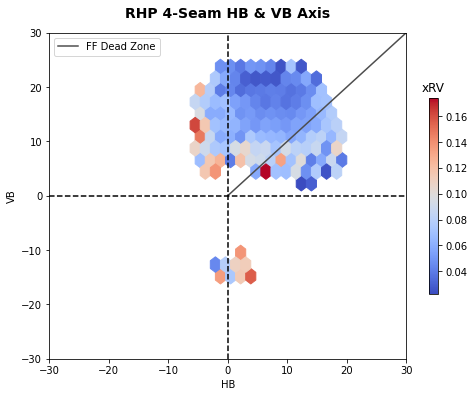

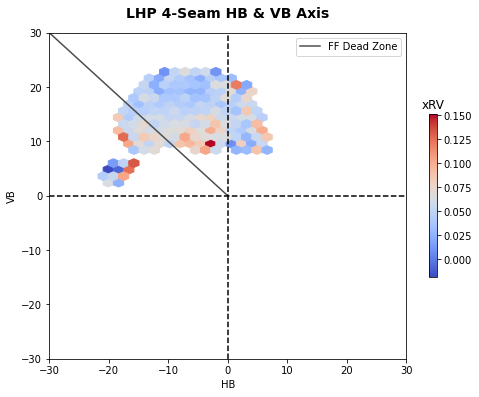

In [11]:
plt.figure(figsize = (8, 6))
plt.hexbin(ff_r_stats['pfx_x'], ff_r_stats['pfx_z'], C = ff_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 20, gridsize = 20)
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(shrink = .6)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('RHP 4-Seam HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(ff_l_stats['pfx_x'], ff_l_stats['pfx_z'], C = ff_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 20, gridsize = 20)
plt.plot([0, -30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('LHP 4-Seam HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Best 4-Seam Heatmaps

In [12]:
lorenzen = xrv.loc[(xrv['player_name'] == 'Lorenzen, Michael') & (xrv['pitch_type'] == 'FF')]
cishek = xrv.loc[(xrv['player_name'] == 'Cishek, Steve') & (xrv['pitch_type'] == 'FF')]

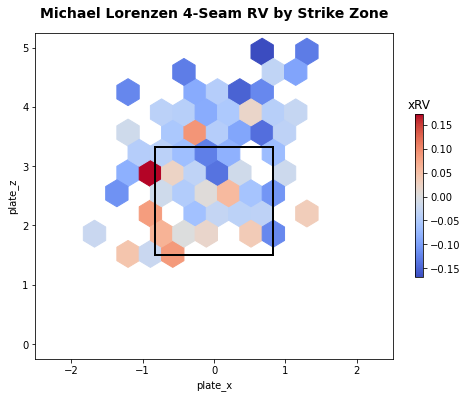

In [13]:
plt.figure(figsize = (8, 6))

plt.hexbin(lorenzen['plate_x'], lorenzen['plate_z'], C = lorenzen['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.5, 2.5), plt.ylim(-.25, 5.25)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Michael Lorenzen 4-Seam RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

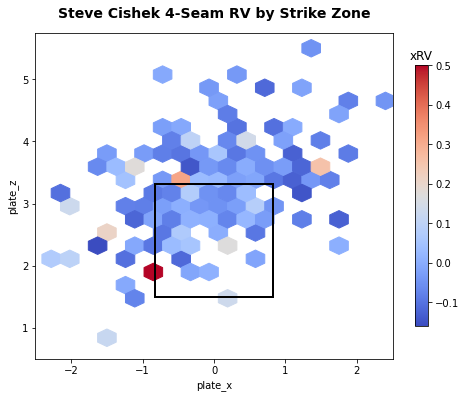

In [14]:
plt.figure(figsize = (8, 6))

plt.hexbin(cishek['plate_x'], cishek['plate_z'], C = cishek['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .8)
cb.ax.set_title('xRV')
plt.xlim(-2.5, 2.5), plt.ylim(.5, 5.75)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Steve Cishek 4-Seam RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

# Cutter Analysis

In [15]:
fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']

fc_r_stats = fc_stats.loc[fc_stats['p_throws'] == 'R']
fc_l_stats = fc_stats.loc[fc_stats['p_throws'] == 'L']

fc_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.0,47442.000000
mean,88.526477,2369.323743,-1.380774,7.923867,0.427809,5.901672,43.681936,6.260598,-0.158903,2.327181,0.039397,1.0,0.048929
std,3.403390,235.369693,3.867322,4.155338,1.993341,0.430094,26.351151,0.378557,0.855116,0.888757,0.304585,0.0,0.179327
min,74.200000,360.000000,-18.000000,-14.520000,-4.400000,3.600000,5.500000,4.400000,-3.940000,-3.100000,-0.203000,1.0,-0.185000
25%,86.200000,2213.000000,-4.320000,5.400000,-1.670000,5.610000,26.400000,6.000000,-0.760000,1.750000,-0.016000,1.0,-0.019000
50%,88.300000,2363.000000,-1.680000,7.800000,1.180000,5.910000,35.900000,6.300000,-0.180000,2.330000,-0.004000,1.0,0.010000
75%,90.500000,2525.000000,1.440000,10.440000,1.890000,6.220000,49.700000,6.500000,0.440000,2.920000,0.001000,1.0,0.058000
max,102.600000,3195.000000,16.080000,23.280000,4.010000,7.100000,151.000000,7.900000,3.250000,5.970000,2.128000,1.0,1.733000


### Top 10 Cutter xRV/100

In [16]:
fc_leaders = fc.sort_values(by = ['xRV/100'])
fc_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
fc_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100
971,"Alvarado, José",L,FC,170.0,94.1,1.26,5.10,25.5,6.73,-5.186,-3.05
984,"Enns, Dietrich",L,FC,133.0,85.8,3.57,2.73,68.5,6.30,-1.275,-0.96
825,"Chatwood, Tyler",R,FC,214.0,88.9,-4.79,0.59,27.9,6.11,0.083,0.04
976,"Bleier, Richard",L,FC,158.0,87.2,1.05,5.37,97.8,6.53,0.197,0.12
1010,"Newcomb, Sean",L,FC,170.0,87.5,4.15,0.18,48.9,5.85,0.475,0.28
949,"Voth, Austin",R,FC,139.0,90.2,-3.37,7.30,40.2,6.17,0.862,0.62
921,"Rucker, Michael",R,FC,135.0,89.2,-3.74,4.49,35.3,6.20,0.925,0.69
848,"Garcia, Luis",R,FC,565.0,86.1,-5.69,5.22,31.6,6.23,6.097,1.08
845,"Fulmer, Carson",R,FC,106.0,86.6,-4.73,1.34,32.2,6.27,1.644,1.55
841,"Fedde, Erick",R,FC,554.0,89.4,-3.13,6.51,29.0,6.66,8.592,1.55


### Cutter HB & VB

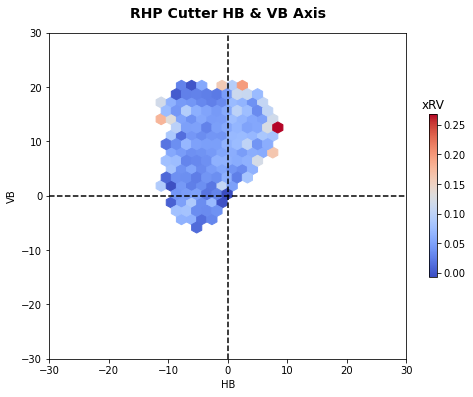

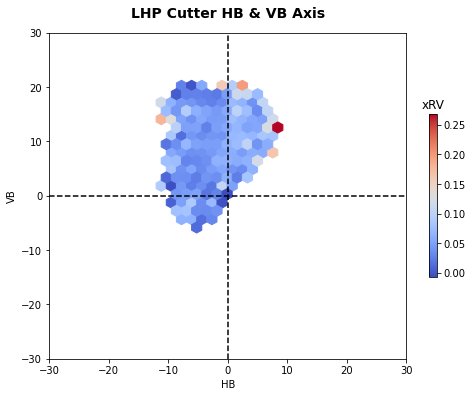

In [17]:
plt.figure(figsize = (8, 6))
plt.hexbin(fc_r_stats['pfx_x'], fc_r_stats['pfx_z'], C = fc_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(fc_r_stats['pfx_x'], fc_r_stats['pfx_z'], C = fc_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Best Cutter Heatmaps

In [18]:
alvarado = xrv.loc[(xrv['player_name'] == 'Alvarado, José') & (xrv['pitch_type'] == 'FC')]

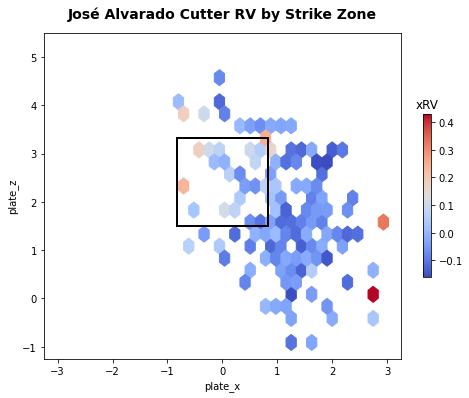

In [19]:
plt.figure(figsize = (8, 6))

plt.hexbin(alvarado['plate_x'], alvarado['plate_z'], C = alvarado['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-3.25, 3.25), plt.ylim(-1.25, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('José Alvarado Cutter RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

# Sinker Analysis

In [20]:
si_stats = xrv.loc[xrv['pitch_type'] == 'SI']
si_r_stats = si_stats.loc[si_stats['p_throws'] == 'R']
si_l_stats = si_stats.loc[si_stats['p_throws'] == 'L']

si_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.0,109145.000000
mean,93.006648,2123.474351,5.647514,9.230005,0.655727,5.730723,44.452854,6.307131,0.076329,2.335188,0.058455,1.0,0.068317
std,2.971813,185.031830,14.019857,4.767433,1.982204,0.591366,24.954539,0.449247,0.831188,0.796774,0.310015,0.0,0.181089
min,66.300000,267.000000,-25.440000,-16.320000,-4.610000,0.970000,0.800000,3.800000,-4.110000,-1.640000,-0.203000,1.0,-0.186000
25%,91.300000,2006.000000,-12.600000,6.480000,-1.420000,5.510000,29.000000,6.000000,-0.500000,1.810000,-0.016000,1.0,-0.007000
50%,93.100000,2121.000000,13.320000,9.720000,1.410000,5.790000,36.700000,6.300000,0.080000,2.320000,-0.004000,1.0,0.024000
75%,94.900000,2240.000000,15.960000,12.480000,2.060000,6.090000,47.900000,6.600000,0.650000,2.850000,0.001000,1.0,0.076000
max,103.400000,3550.000000,29.040000,24.240000,4.630000,7.070000,168.400000,8.600000,4.390000,9.210000,2.128000,1.0,1.647000


### Top 10 Sinker xRV/100

In [21]:
si_leaders = si.sort_values(by = ['xRV/100'])
si_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
si_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100
1259,"Nola, Aaron",R,SI,419.0,92.1,17.48,8.83,36.0,6.93,4.478,1.07
1497,"Rodriguez, Eduardo",L,SI,305.0,92.5,-14.88,10.02,49.1,6.06,3.341,1.10
1306,"Sadler, Casey",R,SI,156.0,93.1,16.62,8.86,24.3,6.11,1.924,1.23
1070,"Burnes, Corbin",R,SI,236.0,96.9,11.89,12.07,16.4,6.43,3.083,1.31
1521,"Suárez, Ranger",L,SI,734.0,92.9,-15.77,7.81,77.2,6.21,11.038,1.50
1108,"DeSclafani, Anthony",R,SI,473.0,94.0,15.56,11.19,31.8,6.59,9.362,1.98
1104,"Darvish, Yu",R,SI,229.0,94.0,13.54,13.04,31.4,6.32,5.367,2.34
1152,"Graveman, Kendall",R,SI,548.0,96.6,16.39,10.63,24.2,6.37,15.538,2.84
1499,"Rogers, Taylor",L,SI,295.0,95.7,-17.36,7.19,54.2,5.67,8.580,2.91
1215,"Loáisiga, Jonathan",R,SI,595.0,98.3,15.60,11.78,36.9,6.59,17.463,2.93


## Sinker HB & VB

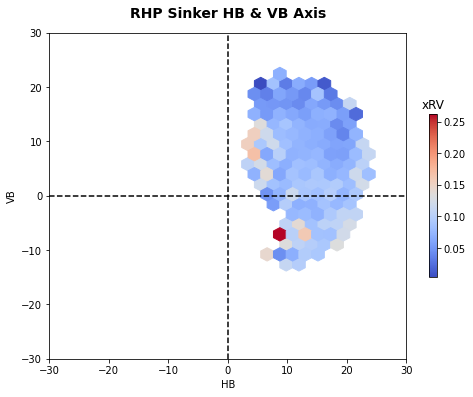

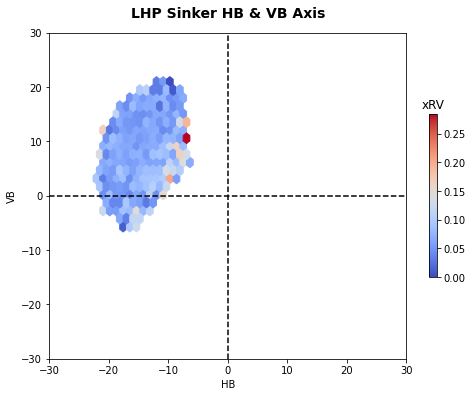

In [22]:
plt.figure(figsize = (8, 6))
plt.hexbin(si_r_stats['pfx_x'], si_r_stats['pfx_z'], C = si_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(si_l_stats['pfx_x'], si_l_stats['pfx_z'], C = si_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Best Sinker Heatmaps

In [23]:
nola = xrv.loc[(xrv['player_name'] == 'Nola, Aaron') & (xrv['pitch_type'] == 'SI')]
rodriguez = xrv.loc[(xrv['player_name'] == 'Rodriguez, Eduardo') & (xrv['pitch_type'] == 'SI')]

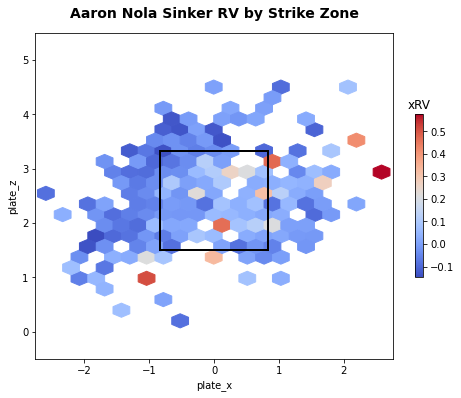

In [24]:
plt.figure(figsize = (8, 6))

plt.hexbin(nola['plate_x'], nola['plate_z'], C = nola['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.75, 2.75), plt.ylim(-.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Aaron Nola Sinker RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

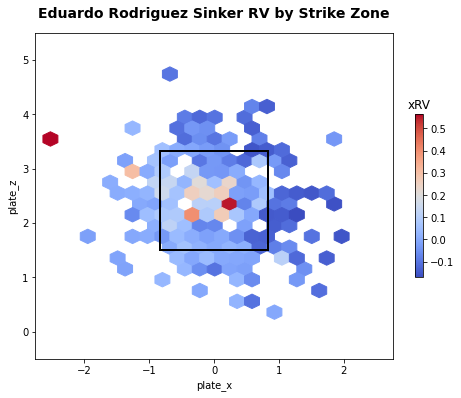

In [25]:
plt.figure(figsize = (8, 6))

plt.hexbin(rodriguez['plate_x'], rodriguez['plate_z'], C = rodriguez['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.75, 2.75), plt.ylim(-.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Eduardo Rodriguez Sinker RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

# Slider Analysis

In [26]:
sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
sl_r_stats = sl_stats.loc[sl_stats['p_throws'] == 'R']
sl_l_stats = sl_stats.loc[sl_stats['p_throws'] == 'L']

sl_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.0,135533.000000
mean,84.652361,2417.424502,-3.221783,1.704358,0.931846,5.795487,41.499239,6.258316,-0.232509,1.885368,0.008699,1.0,0.016807
std,3.512708,264.636892,7.422867,4.433631,1.874394,0.594536,21.038328,0.457759,0.919451,0.934011,0.286980,0.0,0.170835
min,35.900000,291.000000,-34.080000,-19.680000,-4.370000,0.940000,2.100000,3.600000,-4.890000,-5.070000,-0.203000,1.0,-0.187000
25%,82.600000,2239.000000,-7.320000,-1.320000,-0.580000,5.560000,29.000000,5.900000,-0.860000,1.280000,-0.149000,1.0,-0.058000
50%,85.000000,2410.000000,-3.480000,1.680000,1.600000,5.860000,37.000000,6.300000,-0.260000,1.890000,-0.007000,1.0,-0.011000
75%,87.000000,2585.000000,1.200000,4.680000,2.230000,6.160000,46.800000,6.600000,0.380000,2.500000,-0.004000,1.0,0.030000
max,95.500000,3600.000000,26.640000,28.800000,4.670000,7.440000,168.600000,8.400000,4.740000,9.390000,2.128000,1.0,1.639000


### Top 10 Slider xRV/100

In [27]:
sl_leaders = sl.sort_values(by = ['xRV/100'])
sl_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
sl_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100
2072,"Bummer, Aaron",L,SL,281.0,83.0,17.92,-5.02,81.8,6.01,-15.491,-5.51
1739,"Hendriks, Liam",R,SL,235.0,89.0,-1.91,3.24,30.4,6.86,-10.276,-4.37
1798,"Leone, Dominic",R,SL,230.0,83.7,-5.68,-3.73,37.7,6.55,-9.819,-4.27
2178,"Rodón, Carlos",L,SL,603.0,85.8,8.21,-1.06,66.6,6.00,-24.396,-4.05
1653,"Dunn, Justin",R,SL,129.0,84.0,-7.05,-1.28,25.8,6.47,-4.614,-3.58
2204,"Steele, Justin",L,SL,161.0,83.0,12.73,-2.92,66.1,6.34,-5.282,-3.28
2070,"Brothers, Rex",L,SL,344.0,86.2,1.02,1.37,63.2,5.91,-10.143,-2.95
2050,"deGrom, Jacob",R,SL,409.0,91.6,-4.67,3.46,24.0,6.81,-10.218,-2.50
2075,"Chafin, Andrew",L,SL,250.0,82.5,1.07,-1.82,46.8,6.61,-5.941,-2.38
1894,"Phillips, Evan",R,SL,108.0,84.4,-15.29,0.47,44.1,6.28,-2.566,-2.38


## Slider HB & VB

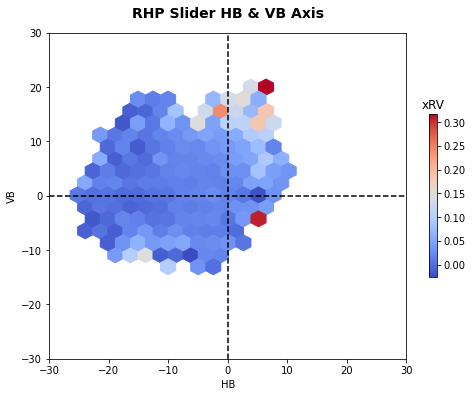

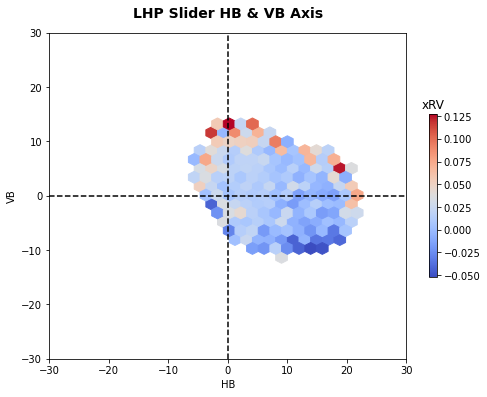

In [28]:
plt.figure(figsize = (8, 6))
plt.hexbin(sl_r_stats['pfx_x'], sl_r_stats['pfx_z'], C = sl_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(sl_l_stats['pfx_x'], sl_l_stats['pfx_z'], C = sl_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Best Slider Heatmaps

In [29]:
hendriks = xrv.loc[(xrv['player_name'] == 'Hendriks, Liam') & (xrv['pitch_type'] == 'SL')]
steele = xrv.loc[(xrv['player_name'] == 'Steele, Justin') & (xrv['pitch_type'] == 'SL')]
deGrom = xrv.loc[(xrv['player_name'] == 'deGrom, Jacob') & (xrv['pitch_type'] == 'SL')]

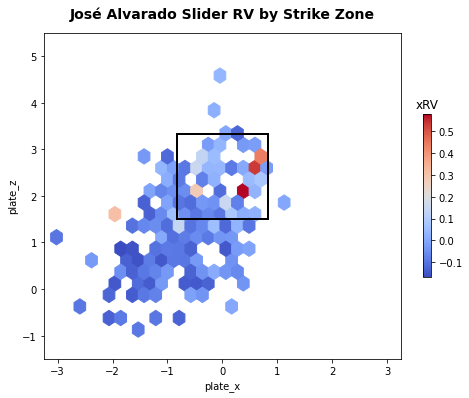

In [30]:
plt.figure(figsize = (8, 6))

plt.hexbin(hendriks['plate_x'], hendriks['plate_z'], C = hendriks['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-3.25, 3.25), plt.ylim(-1.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('José Alvarado Slider RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

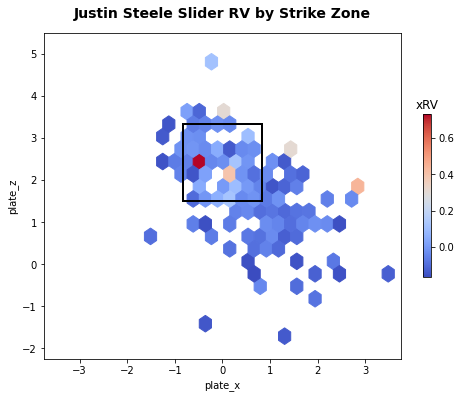

In [31]:
plt.figure(figsize = (8, 6))

plt.hexbin(steele['plate_x'], steele['plate_z'], C = steele['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-3.75, 3.75), plt.ylim(-2.25, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Justin Steele Slider RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

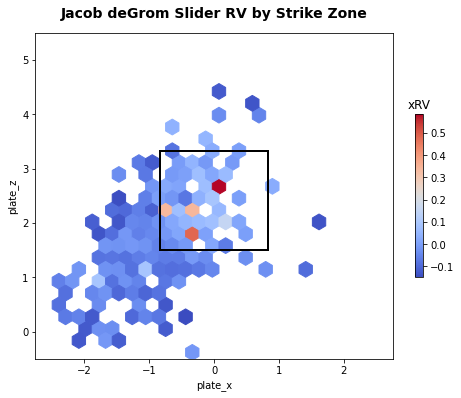

In [32]:
plt.figure(figsize = (8, 6))

plt.hexbin(deGrom['plate_x'], deGrom['plate_z'], C = deGrom['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.75, 2.75), plt.ylim(-.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Jacob deGrom Slider RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

# Curveball Analysis

In [33]:
cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
cu_r_stats = cu_stats.loc[cu_stats['p_throws'] == 'R']
cu_l_stats = cu_stats.loc[cu_stats['p_throws'] == 'L']

cu_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.0,58770.000000
mean,78.744136,2506.825898,-3.862663,-8.741015,0.516107,5.975537,39.111656,6.208064,-0.068508,1.833346,0.000856,1.0,0.007733
std,3.886024,324.934051,9.996679,5.847554,1.820407,0.428738,23.447448,0.427571,0.881018,1.072030,0.264672,0.0,0.157243
min,39.600000,95.000000,-29.400000,-25.560000,-4.430000,1.870000,0.700000,2.800000,-8.830000,-4.320000,-0.203000,1.0,-0.192000
25%,76.500000,2287.000000,-11.520000,-13.200000,-1.350000,5.720000,25.300000,5.900000,-0.640000,1.150000,-0.149000,1.0,-0.060000
50%,79.200000,2499.000000,-6.360000,-9.480000,1.220000,6.020000,33.500000,6.200000,-0.070000,1.840000,-0.007000,1.0,-0.012000
75%,81.400000,2731.000000,3.720000,-4.680000,1.880000,6.250000,45.900000,6.500000,0.500000,2.530000,-0.004000,1.0,0.023000
max,91.500000,3722.000000,27.840000,21.600000,5.340000,7.930000,160.800000,7.800000,5.000000,8.800000,2.128000,1.0,1.540000


### Top 10 Curveball xRV/100

In [34]:
cu_leaders = cu.sort_values(by = ['xRV/100'])
cu_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
cu_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100
2329,"Glasnow, Tyler",R,CU,183.0,83.5,-4.63,-17.54,27.0,7.17,-16.508,-9.02
2357,"Hendriks, Liam",R,CU,107.0,85.8,-2.66,-9.49,30.2,6.74,-8.808,-8.23
2630,"Luetge, Lucas",L,CU,189.0,74.5,12.36,-15.41,7.0,6.17,-13.870,-7.34
2525,"Trivino, Lou",R,CU,133.0,77.8,-13.31,-7.84,25.3,6.45,-4.826,-3.63
2245,"Bassitt, Chris",R,CU,155.0,71.7,-13.57,-13.51,17.1,6.32,-5.502,-3.55
2264,"Burnes, Corbin",R,CU,473.0,81.2,-11.27,-7.84,11.7,6.32,-14.302,-3.02
2416,"McKenzie, Triston",R,CU,356.0,79.3,-6.11,-8.86,34.1,6.64,-10.373,-2.91
2517,"Thompson, Keegan",R,CU,222.0,82.5,-8.05,-12.47,32.8,6.10,-6.254,-2.82
2551,"Woodruff, Brandon",R,CU,468.0,83.8,-4.54,-12.31,26.5,6.37,-10.703,-2.29
2505,"Staumont, Josh",R,CU,380.0,81.3,-9.70,-12.76,22.4,6.47,-8.405,-2.21


## Curveball HB & VB

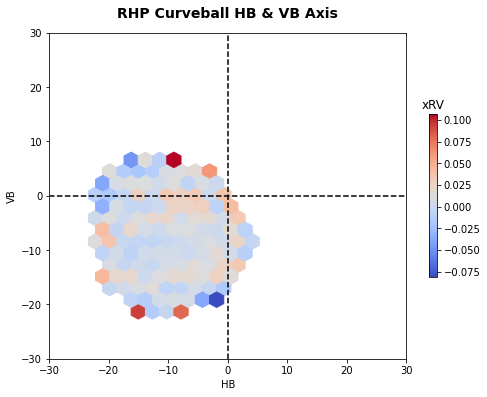

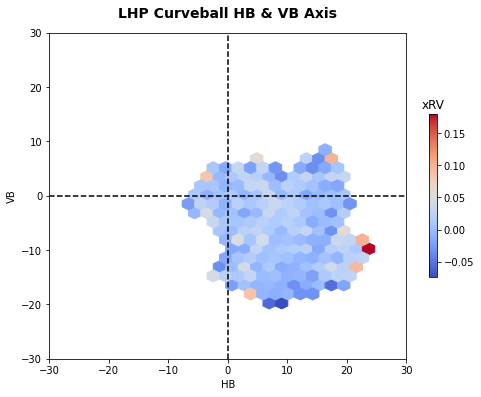

In [35]:
plt.figure(figsize = (8, 6))
plt.hexbin(cu_r_stats['pfx_x'], cu_r_stats['pfx_z'], C = cu_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 15, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(cu_l_stats['pfx_x'], cu_l_stats['pfx_z'], C = cu_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 15, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Bets Curveball Heatmaps

In [36]:
glasnow = xrv.loc[(xrv['player_name'] == 'Glasnow, Tyler') & (xrv['pitch_type'] == 'CU')]
burnes = xrv.loc[(xrv['player_name'] == 'Burnes, Corbin') & (xrv['pitch_type'] == 'CU')]

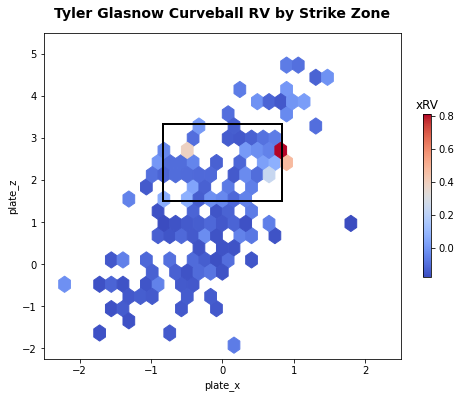

In [37]:
plt.figure(figsize = (8, 6))

plt.hexbin(glasnow['plate_x'], glasnow['plate_z'], C = glasnow['xRV'], cmap = 'coolwarm', gridsize = 25)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.5, 2.5), plt.ylim(-2.25, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Tyler Glasnow Curveball RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

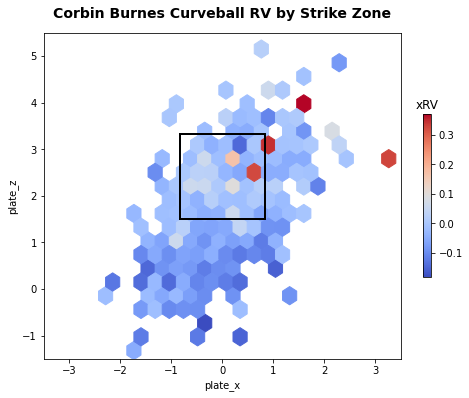

In [38]:
plt.figure(figsize = (8, 6))

plt.hexbin(burnes['plate_x'], burnes['plate_z'], C = burnes['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-3.5, 3.5), plt.ylim(-1.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Corbin Burnes Curveball RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

# Changeup Analysis

In [39]:
ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']
ch_r_stats = ch_stats.loc[ch_stats['p_throws'] == 'R']
ch_l_stats = ch_stats.loc[ch_stats['p_throws'] == 'L']

ch_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.0,80330.000000
mean,84.806887,1749.619781,3.593931,6.828759,0.469775,5.796717,45.671474,6.306985,0.040431,1.850276,0.023993,1.0,0.033105
std,3.524400,299.480706,13.825781,4.907631,2.039148,0.440081,23.259922,0.452686,0.874606,0.901523,0.300844,0.0,0.179340
min,43.800000,43.000000,-27.000000,-15.720000,-4.460000,2.160000,0.100000,3.700000,-9.110000,-3.580000,-0.203000,1.0,-0.187000
25%,82.600000,1546.000000,-12.720000,3.600000,-1.710000,5.530000,31.200000,6.000000,-0.560000,1.260000,-0.149000,1.0,-0.040000
50%,85.100000,1714.000000,11.160000,6.960000,1.400000,5.820000,38.700000,6.300000,0.050000,1.840000,-0.007000,1.0,-0.001000
75%,87.200000,1935.000000,15.120000,10.200000,2.090000,6.090000,51.800000,6.600000,0.630000,2.420000,0.000000,1.0,0.046000
max,95.500000,3595.000000,29.640000,23.400000,4.580000,7.280000,164.600000,9.000000,4.680000,8.390000,2.128000,1.0,1.593000


### Top 10 Changeup xRV/100

In [40]:
ch_leaders = ch.sort_values(by = ['xRV/100'])
ch_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
ch_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100
3052,"Romo, Sergio",R,CH,112.0,80.2,20.43,4.34,48.2,6.517857,-3.732,-3.33
2934,"Knehr, Reiss",R,CH,116.0,88.9,16.19,4.80,35.1,6.602586,-2.133,-1.84
3243,"Kikuchi, Yusei",L,CH,269.0,86.2,-10.65,5.37,59.9,6.800000,-2.758,-1.03
3066,"Scherzer, Max",R,CH,421.0,85.0,15.16,3.95,49.4,6.435629,-4.156,-0.99
3099,"Sulser, Cole",R,CH,355.0,84.0,13.49,5.60,32.6,6.701408,-3.388,-0.95
2823,"Fedde, Erick",R,CH,245.0,87.7,14.55,1.56,34.6,6.600000,-1.468,-0.60
2833,"Flexen, Chris",R,CH,431.0,82.7,12.22,9.60,15.6,5.978190,-2.538,-0.59
2926,"Kelly, Joe",R,CH,115.0,86.9,17.69,5.73,33.6,5.957391,-0.658,-0.57
2875,"Greinke, Zack",R,CH,569.0,86.4,12.77,4.46,25.0,5.908436,-2.762,-0.49
2705,"Alzolay, Adbert",R,CH,138.0,85.6,13.97,9.47,33.5,6.170290,-0.539,-0.39


### Changeup HB & VB

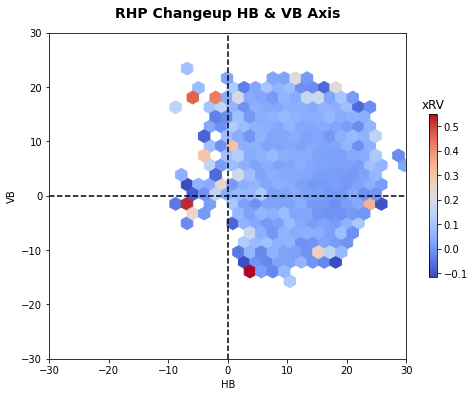

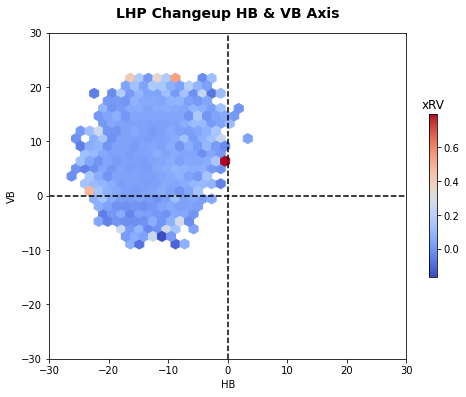

In [41]:
plt.figure(figsize = (8, 6))
plt.hexbin(ch_r_stats['pfx_x'], ch_r_stats['pfx_z'], C = ch_r_stats['xRV'], cmap = 'coolwarm', gridsize = 20)
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('RV')
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(ch_l_stats['pfx_x'], ch_l_stats['pfx_z'], C = ch_l_stats['xRV'], cmap = 'coolwarm', gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### Best Changeup Heatmaps

In [42]:
scherzer = xrv.loc[(xrv['player_name'] == 'Scherzer, Max') & (xrv['pitch_type'] == 'CH')]
greinke = xrv.loc[(xrv['player_name'] == 'Greinke, Zack') & (xrv['pitch_type'] == 'CH')]

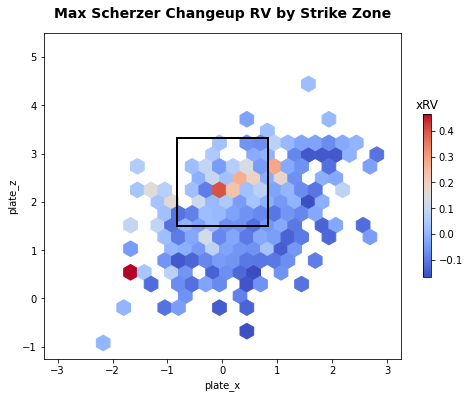

In [43]:
plt.figure(figsize = (8, 6))

plt.hexbin(scherzer['plate_x'], scherzer['plate_z'], C = scherzer['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z') 
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-3.25, 3.25), plt.ylim(-1.25, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Max Scherzer Changeup RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

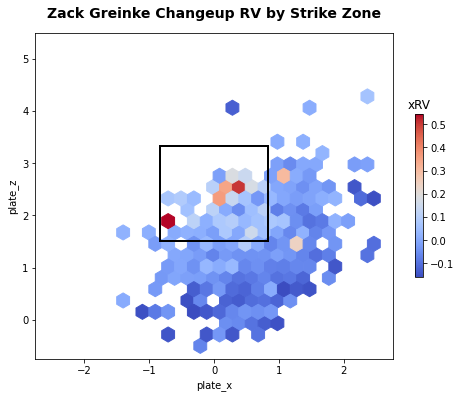

In [44]:
plt.figure(figsize = (8, 6))

plt.hexbin(greinke['plate_x'], greinke['plate_z'], C = greinke['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.75, 2.75), plt.ylim(-.75, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Zack Greinke Changeup RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

# Clayton Kershaw Arsenal

In [45]:
kershaw_sl = xrv.loc[(xrv['player_name'] == 'Kershaw, Clayton') & (xrv['pitch_type'] == 'SL')]
print('Slider:', kershaw_sl.shape)
kershaw_ff = xrv.loc[(xrv['player_name'] == 'Kershaw, Clayton') & (xrv['pitch_type'] == 'FF')]
print('4-Seam:', kershaw_ff.shape)
kershaw_cu = xrv.loc[(xrv['player_name'] == 'Kershaw, Clayton') & (xrv['pitch_type'] == 'CU')]
print('Curveball:', kershaw_cu.shape)

Slider: (859, 17)
4-Seam: (661, 17)
Curveball: (273, 17)


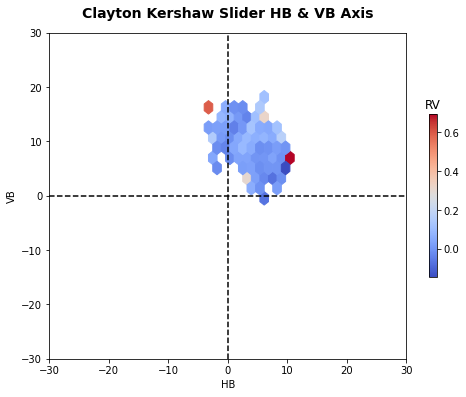

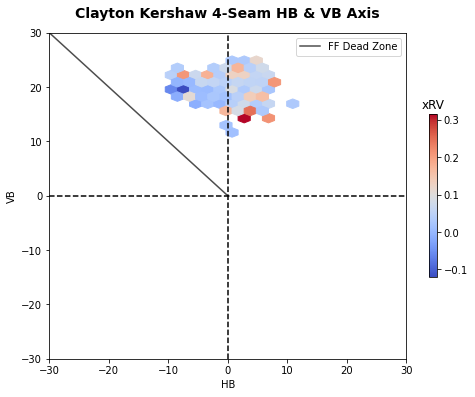

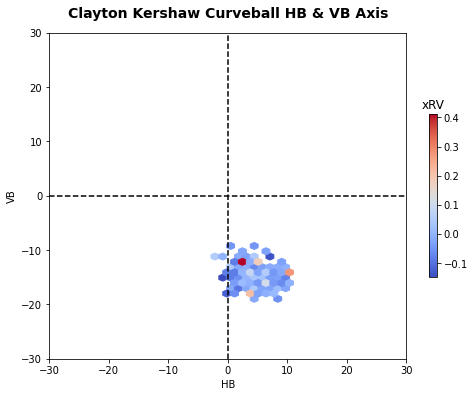

In [46]:
plt.figure(figsize = (8, 6))
plt.hexbin(kershaw_sl['pfx_x'], kershaw_sl['pfx_z'], C = kershaw_sl['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('HB'), plt.ylabel('VB')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('RV')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Clayton Kershaw Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(kershaw_ff['pfx_x'], kershaw_ff['pfx_z'], C = kershaw_ff['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.plot([0, -30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone'), plt.legend()
plt.xlabel('HB'), plt.ylabel('VB')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Clayton Kershaw 4-Seam HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(kershaw_cu['pfx_x'], kershaw_cu['pfx_z'], C = kershaw_cu['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('HB'), plt.ylabel('VB')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Clayton Kershaw Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Grouped Pitches

## Fastball
4-Seam, Cutter, Sinker

In [47]:
fastball_stats = xrv[xrv['pitch_type'].isin(['FF', 'FC', 'SI'])]
print(fastball_stats.shape)

fastball_r_stats = fastball_stats.loc[fastball_stats['p_throws'] == 'R']
fastball_l_stats = fastball_stats.loc[fastball_stats['p_throws'] == 'L']

fastball_stats.describe()

(406250, 17)


,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.0,406250.000000
mean,92.910522,2244.299131,3.102286,13.300776,0.657699,5.864830,41.301202,6.338833,0.000806,2.585154,0.042981,1.0,0.053905
std,3.211609,206.380993,9.801343,5.236159,1.889133,0.534216,22.954575,0.439245,0.798952,0.873999,0.309645,0.0,0.181692
min,59.200000,117.000000,-25.440000,-19.080000,-4.610000,0.970000,0.800000,3.600000,-4.110000,-3.100000,-0.203000,1.0,-0.191000
25%,91.200000,2109.000000,-4.560000,10.080000,-1.310000,5.620000,27.400000,6.000000,-0.550000,2.000000,-0.016000,1.0,-0.017000
50%,93.300000,2243.000000,4.920000,14.520000,1.370000,5.900000,35.500000,6.300000,-0.000000,2.570000,-0.004000,1.0,0.016000
75%,95.100000,2376.000000,10.800000,17.160000,2.020000,6.190000,46.600000,6.600000,0.550000,3.160000,0.001000,1.0,0.065000
max,103.400000,3594.000000,29.040000,27.960000,4.640000,7.190000,168.400000,8.600000,4.390000,9.210000,2.128000,1.0,1.733000


### Fastball xRV/100 Leaders

In [48]:
fastball_leaders = rv_pitches[rv_pitches['pitch_type'].isin(['FF', 'FC', 'SI'])]
fastball_leaders = fastball_leaders.sort_values(by = ['xRV/100'])
fastball_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
fastball_leaders['quality'] = [-x if x > 0 else -x for x in fastball_leaders['xRV/100']]
fastball_leaders.head(10)

scaler = StandardScaler(with_mean = False, with_std = False).fit(fastball_leaders[['quality']])
rv_scaled = scaler.transform(fastball_leaders[['quality']] + 150)

fastball_leaders['quality+'] = rv_scaled
fastball_leaders['quality+'] = round(fastball_leaders['quality+']).astype(int)
fastball_leaders.drop(columns = ['quality'], inplace = True)

fastball_r_lead = fastball_leaders.loc[fastball_leaders['p_throws'] == 'R']
fastball_l_lead = fastball_leaders.loc[fastball_leaders['p_throws'] == 'L']
fastball_r_lead['velo_bucket'] = pd.qcut(fastball_r_lead['velo'], 4, labels = [1, 2, 3, 4])
fastball_l_lead['velo_bucket'] = pd.qcut(fastball_l_lead['velo'], 4, labels = [1, 2, 3, 4])
bucket_1_r = fastball_r_lead.loc[fastball_r_lead['velo_bucket'] == 1]
bucket_2_r = fastball_r_lead.loc[fastball_r_lead['velo_bucket'] == 2]
bucket_3_r = fastball_r_lead.loc[fastball_r_lead['velo_bucket'] == 3]
bucket_4_r = fastball_r_lead.loc[fastball_r_lead['velo_bucket'] == 4]

bucket_1_l = fastball_l_lead.loc[fastball_l_lead['velo_bucket'] == 1]
bucket_2_l = fastball_l_lead.loc[fastball_l_lead['velo_bucket'] == 2]
bucket_3_l = fastball_l_lead.loc[fastball_l_lead['velo_bucket'] == 3]
bucket_4_l = fastball_l_lead.loc[fastball_l_lead['velo_bucket'] == 4]

fastball_leaders.head()

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100,quality+
1096,"Crawford, Kutter",R,SI,2.0,95.8,10.98,17.64,36.8,6.5,-0.237,-11.85,162
1481,"Newcomb, Sean",L,SI,1.0,95.5,-10.68,18.24,40.8,5.9,-0.102,-10.20,160
158,"Fernández, Junior",R,FF,2.0,99.4,6.00,16.20,27.3,6.5,-0.198,-9.90,160
1435,"Garrett, Amir",L,SI,1.0,94.8,-19.20,11.64,108.2,6.8,-0.091,-9.10,159
887,"Maton, Nick",R,FC,1.0,87.0,4.56,15.96,27.9,4.7,-0.090,-9.00,159


bucket 1: 74.4 - 91.1

bucket 2: 91.2 - 93.2

bucket 3: 93.3 - 94.8

bucket 4: 94.9 - 100.6

### Fastball HB & VB

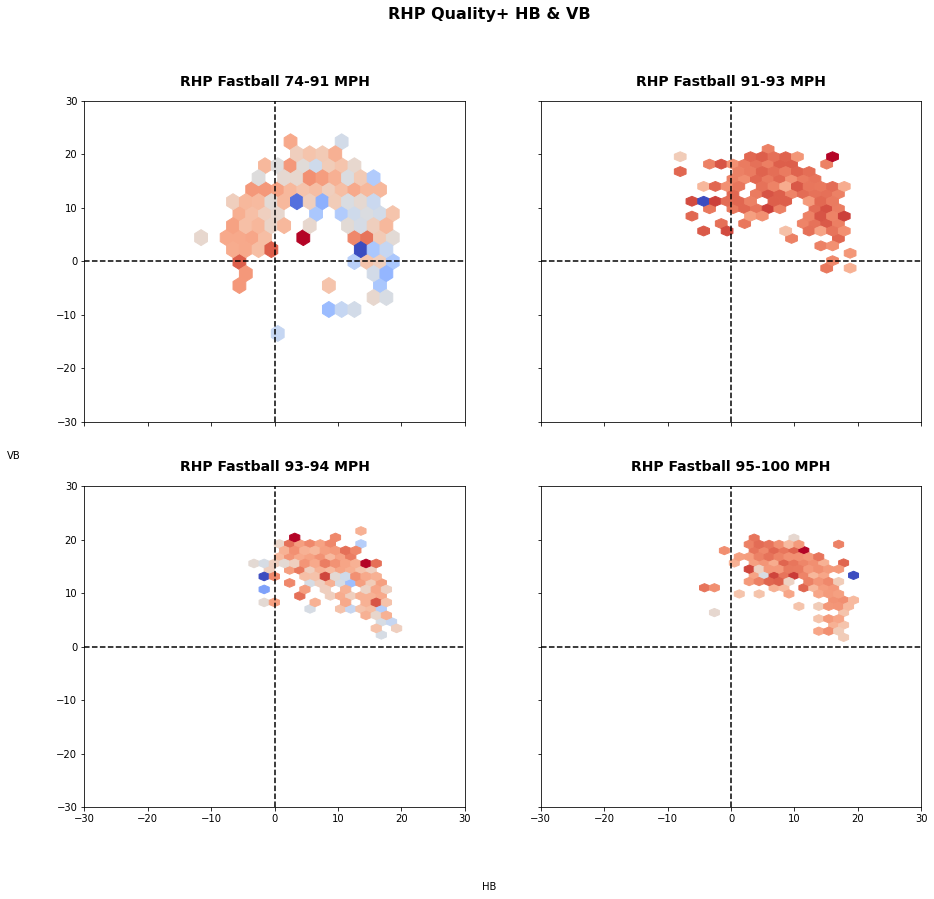

In [49]:
fig, axs = plt.subplots(2, 2, figsize = (15, 13), sharex = True, sharey = True)
fig.suptitle('RHP Quality+ HB & VB', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -30, xmax = 30), plt.axis(ymin = -30, ymax = 30)
fig.text(0.5, 0.04, 'HB', ha='center', va='center'), fig.text(0.06, 0.5, 'VB', ha='center', va='center')
axs[0][0].hexbin(bucket_1_r['pfx_x'], bucket_1_r['pfx_z'], C = bucket_1_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][0].axhline(0, color = 'black', ls = '--'),
axs[0][0].axvline(0, color = 'black', ls = '--')
axs[0][0].set_title('RHP Fastball 74-91 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[0][1].hexbin(bucket_2_r['pfx_x'], bucket_2_r['pfx_z'], C = bucket_2_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][1].axhline(0, color = 'black', ls = '--'),
axs[0][1].axvline(0, color = 'black', ls = '--')
axs[0][1].set_title('RHP Fastball 91-93 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][0].hexbin(bucket_3_r['pfx_x'], bucket_3_r['pfx_z'], C = bucket_3_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)

axs[1][0].axhline(0, color = 'black', ls = '--'),
axs[1][0].axvline(0, color = 'black', ls = '--')
axs[1][0].set_title('RHP Fastball 93-94 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][1].hexbin(bucket_4_r['pfx_x'], bucket_4_r['pfx_z'], C = bucket_4_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[1][1].axhline(0, color = 'black', ls = '--'),
axs[1][1].axvline(0, color = 'black', ls = '--')
axs[1][1].set_title('RHP Fastball 95-100 MPH', fontsize = 14, fontweight = 'bold', pad = 15);

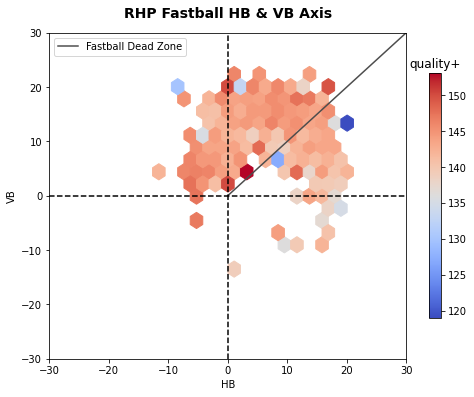

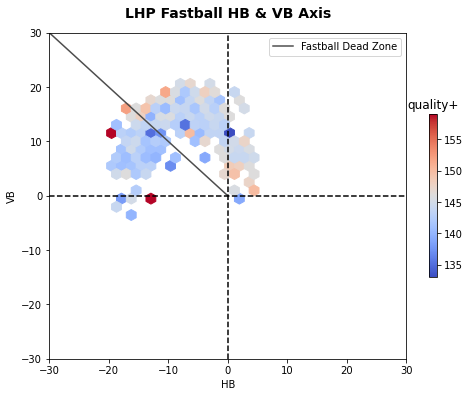

In [50]:
plt.figure(figsize = (8, 6))
plt.hexbin(fastball_r_lead['pfx_x'], fastball_r_lead['pfx_z'], C = fastball_r_lead['quality+'], 
           cmap = 'coolwarm', gridsize = 15)
plt.plot([30, 0], [30, 0], ls="-", c=".3", label = 'Fastball Dead Zone'), plt.legend()
cb = plt.colorbar(shrink = .75)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(fastball_l_lead['pfx_x'], fastball_l_lead['pfx_z'], C = fastball_l_lead['quality+'], 
           cmap = 'coolwarm', gridsize = 15)
plt.plot([0, -30], [0, 30], ls="-", c=".3", label = 'Fastball Dead Zone'), plt.legend()
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball
Slider, Curveball, Knuckle Curve

In [51]:
g_sl = xrv.loc[xrv['pitch_type'] == 'SL']
g_cu = xrv.loc[xrv['pitch_type'] == 'CU']
bb_stats = g_sl.append(g_cu)
g_kc = xrv.loc[xrv['pitch_type'] == 'KC']
bb_stats = bb_stats.append(g_kc)
print(bb_stats.shape)

bb_r_stats = bb_stats.loc[bb_stats['p_throws'] == 'R']
bb_l_stats = bb_stats.loc[bb_stats['p_throws'] == 'L']

bb_stats.describe()

(194303, 17)


,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.0,194303.000000
mean,82.865326,2444.465361,-3.415627,-1.455009,0.806099,5.849946,40.777077,6.243116,-0.182905,1.869633,0.006327,1.0,0.014063
std,4.532022,287.177609,8.291327,6.860984,1.868011,0.555874,21.822627,0.449435,0.911115,0.978103,0.280442,0.0,0.166892
min,35.900000,95.000000,-34.080000,-25.560000,-4.430000,0.940000,0.700000,2.800000,-8.830000,-5.070000,-0.203000,1.0,-0.192000
25%,80.100000,2252.000000,-8.880000,-5.520000,-0.910000,5.600000,27.600000,5.900000,-0.800000,1.240000,-0.149000,1.0,-0.058000
50%,83.400000,2431.000000,-4.080000,-0.360000,1.480000,5.900000,35.900000,6.200000,-0.200000,1.880000,-0.007000,1.0,-0.011000
75%,86.100000,2627.000000,1.560000,3.480000,2.130000,6.190000,46.100000,6.500000,0.420000,2.500000,-0.004000,1.0,0.028000
max,95.500000,3722.000000,27.840000,28.800000,5.340000,7.930000,168.600000,8.400000,5.000000,9.390000,2.128000,1.0,1.639000


## Breaking Ball Leaders

In [52]:
bb_leaders = rv_pitches[rv_pitches['pitch_type'].isin(['SL', 'CU', 'KC'])]
bb_leaders = bb_leaders.sort_values(by = ['xRV/100'])
bb_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
bb_leaders['quality'] = [-x if x > 0 else -x for x in bb_leaders['xRV/100']]
bb_leaders.head(10)

scaler = StandardScaler(with_mean = False, with_std = False).fit(bb_leaders[['quality']])
rv_scaled = scaler.transform(bb_leaders[['quality']] + 150)

bb_leaders['quality+'] = rv_scaled
bb_leaders['quality+'] = round(bb_leaders['quality+']).astype(int)
bb_leaders.drop(columns = ['quality'], inplace = True)
bb_r_lead = bb_leaders.loc[bb_leaders['p_throws'] == 'R']
bb_l_lead = bb_leaders.loc[bb_leaders['p_throws'] == 'L']

bb_r_lead['velo_bucket'] = pd.qcut(bb_r_lead['velo'], 4, labels = [1, 2, 3, 4])
bb_l_lead['velo_bucket'] = pd.qcut(bb_l_lead['velo'], 4, labels = [1, 2, 3, 4])
bb_r_lead.head()

bucket_1_r = bb_r_lead.loc[bb_r_lead['velo_bucket'] == 1]
bucket_2_r = bb_r_lead.loc[bb_r_lead['velo_bucket'] == 2]
bucket_3_r = bb_r_lead.loc[bb_r_lead['velo_bucket'] == 3]
bucket_4_r = bb_r_lead.loc[bb_r_lead['velo_bucket'] == 4]

bucket_1_l = bb_l_lead.loc[bb_l_lead['velo_bucket'] == 1]
bucket_2_l = bb_l_lead.loc[bb_l_lead['velo_bucket'] == 2]
bucket_3_l = bb_l_lead.loc[bb_l_lead['velo_bucket'] == 3]
bucket_4_l = bb_l_lead.loc[bb_l_lead['velo_bucket'] == 4]

bb_leaders.head()

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100,quality+
2355,"Hembree, Heath",R,CU,5.0,83.0,-12.77,-10.15,22.1,6.76,-0.654,-13.08,163
2668,"Santiago, Héctor",L,CU,1.0,75.8,5.52,-7.68,85.2,5.70,-0.129,-12.90,163
2647,"Moreland, Mitch",L,CU,2.0,73.3,5.88,-10.02,85.3,5.75,-0.222,-11.10,161
2541,"Weems, Jordan",R,CU,1.0,75.0,-12.00,-12.00,28.4,6.50,-0.108,-10.80,161
2617,"Kickham, Mike",L,CU,4.0,77.2,12.60,-7.20,61.3,6.35,-0.421,-10.52,161


bucket 1: 39.6 - 78.8

bucket 2: 78.9 - 82.3

bucket 3: 82.4 - 85.4

bucket 4:85.5 - 91.9

### Breaking Ball HB & VB

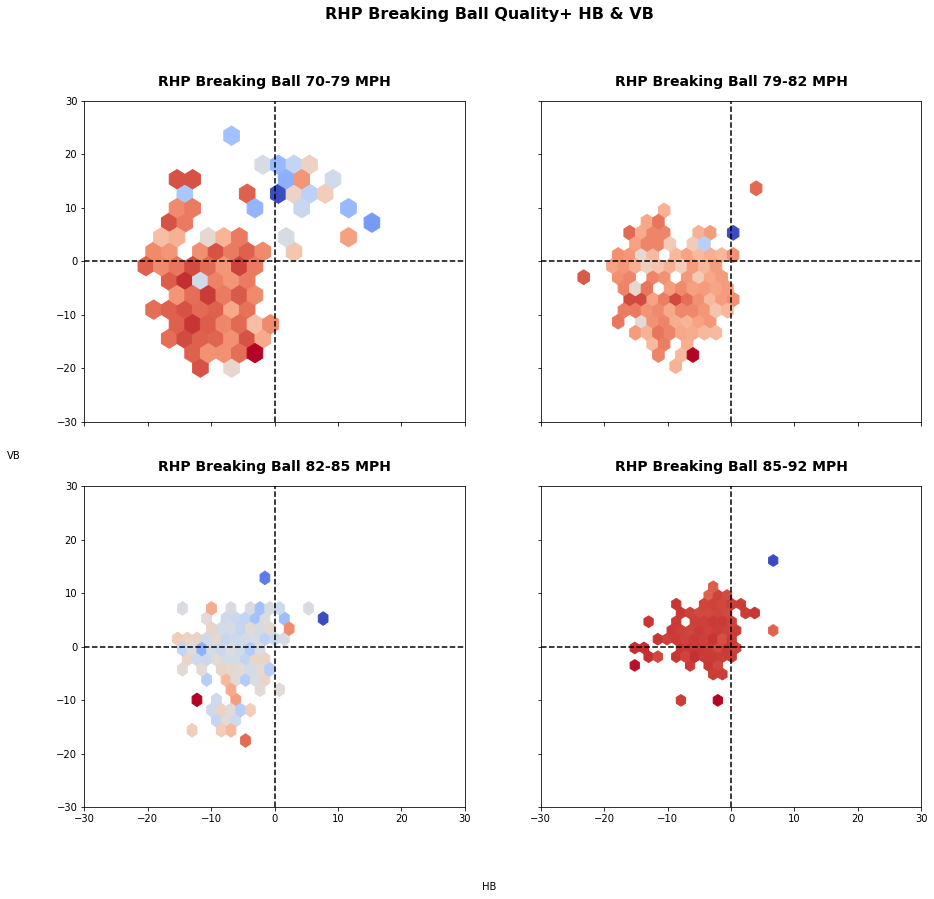

In [53]:
fig, axs = plt.subplots(2, 2, figsize = (15, 13), sharex = True, sharey = True)
fig.suptitle('RHP Breaking Ball Quality+ HB & VB', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -30, xmax = 30), plt.axis(ymin = -30, ymax = 30) 
fig.text(0.5, 0.04, 'HB', ha='center', va='center'), fig.text(0.06, 0.5, 'VB', ha='center', va='center')
axs[0][0].hexbin(bucket_1_r['pfx_x'], bucket_1_r['pfx_z'], C = bucket_1_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][0].axhline(0, color = 'black', ls = '--'),
axs[0][0].axvline(0, color = 'black', ls = '--')
#axs[0][0].fig.colorbar(shrink = .75)
#axs[0][0].ax.set_title('quality+')
axs[0][0].set_title('RHP Breaking Ball 70-79 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[0][1].hexbin(bucket_2_r['pfx_x'], bucket_2_r['pfx_z'], C = bucket_2_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][1].axhline(0, color = 'black', ls = '--'),
axs[0][1].axvline(0, color = 'black', ls = '--')
axs[0][1].set_title('RHP Breaking Ball 79-82 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][0].hexbin(bucket_3_r['pfx_x'], bucket_3_r['pfx_z'], C = bucket_3_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)

axs[1][0].axhline(0, color = 'black', ls = '--'),
axs[1][0].axvline(0, color = 'black', ls = '--')
axs[1][0].set_title('RHP Breaking Ball 82-85 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][1].hexbin(bucket_4_r['pfx_x'], bucket_4_r['pfx_z'], C = bucket_4_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[1][1].axhline(0, color = 'black', ls = '--'),
axs[1][1].axvline(0, color = 'black', ls = '--')
axs[1][1].set_title('RHP Breaking Ball 85-92 MPH', fontsize = 14, fontweight = 'bold', pad = 15);

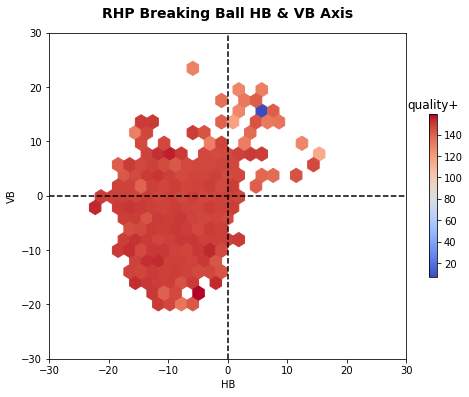

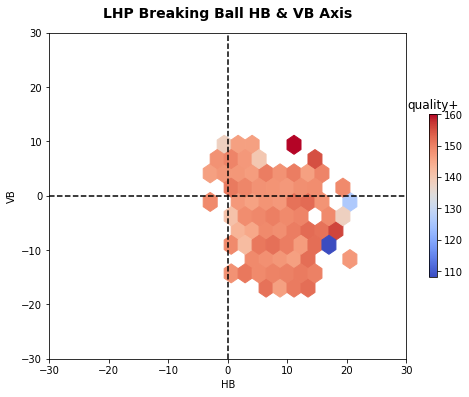

In [54]:
plt.figure(figsize = (8, 6))
plt.hexbin(bb_r_lead['pfx_x'], bb_r_lead['pfx_z'], C = bb_r_lead['quality+'], cmap = 'coolwarm', gridsize = 20)
# mincnt = 10
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(bb_l_lead['pfx_x'], bb_l_lead['pfx_z'], C = bb_l_lead['quality+'], cmap = 'coolwarm', gridsize = 10)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

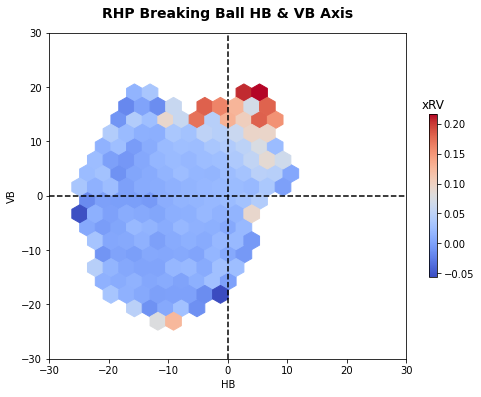

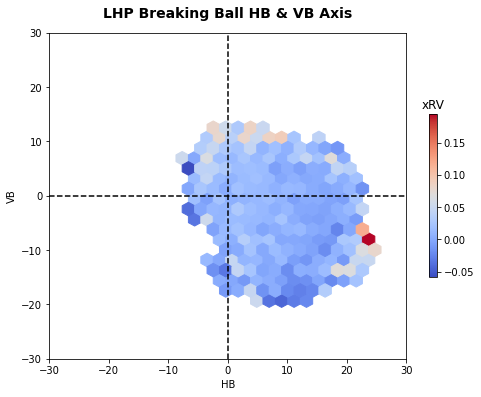

In [55]:
plt.figure(figsize = (8, 6))
plt.hexbin(bb_r_stats['pfx_x'], bb_r_stats['pfx_z'], C = bb_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('xRV'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(bb_l_stats['pfx_x'], bb_l_stats['pfx_z'], C = bb_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('xRV'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-Speed
Changeup, Splitter

In [56]:
g_ch = xrv.loc[xrv['pitch_type'] == 'CH']
g_fs = xrv.loc[xrv['pitch_type'] == 'FS']
os_stats = g_ch.append(g_fs)
print(os_stats.shape)

os_r_stats = os_stats.loc[os_stats['p_throws'] == 'R']
os_l_stats = os_stats.loc[os_stats['p_throws'] == 'L']

os_stats.describe()

(80330, 17)


,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.0,80330.000000
mean,84.806887,1749.619781,3.593931,6.828759,0.469775,5.796717,45.671474,6.306985,0.040431,1.850276,0.023993,1.0,0.033105
std,3.524400,299.480706,13.825781,4.907631,2.039148,0.440081,23.259922,0.452686,0.874606,0.901523,0.300844,0.0,0.179340
min,43.800000,43.000000,-27.000000,-15.720000,-4.460000,2.160000,0.100000,3.700000,-9.110000,-3.580000,-0.203000,1.0,-0.187000
25%,82.600000,1546.000000,-12.720000,3.600000,-1.710000,5.530000,31.200000,6.000000,-0.560000,1.260000,-0.149000,1.0,-0.040000
50%,85.100000,1714.000000,11.160000,6.960000,1.400000,5.820000,38.700000,6.300000,0.050000,1.840000,-0.007000,1.0,-0.001000
75%,87.200000,1935.000000,15.120000,10.200000,2.090000,6.090000,51.800000,6.600000,0.630000,2.420000,0.000000,1.0,0.046000
max,95.500000,3595.000000,29.640000,23.400000,4.580000,7.280000,164.600000,9.000000,4.680000,8.390000,2.128000,1.0,1.593000


### Off-Speed Leaders

In [57]:
os_leaders = rv_pitches[rv_pitches['pitch_type'].isin(['CH', 'FS'])]
os_leaders = os_leaders.sort_values(by = ['xRV/100'])
os_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
os_leaders['quality'] = [-x if x > 0 else -x for x in os_leaders['xRV/100']]
os_leaders.head(10)

scaler = StandardScaler(with_mean = False, with_std = False).fit(os_leaders[['quality']])
rv_scaled = scaler.transform(os_leaders[['quality']] + 150)

os_leaders['quality+'] = rv_scaled
os_leaders['quality+'] = round(os_leaders['quality+']).astype(int)
os_leaders.drop(columns = ['quality'], inplace = True)
os_r_lead = os_leaders.loc[os_leaders['p_throws'] == 'R']
os_l_lead = os_leaders.loc[os_leaders['p_throws'] == 'L']

os_r_lead['velo_bucket'] = pd.qcut(os_r_lead['velo'], 4, labels = [1, 2, 3, 4])
os_l_lead['velo_bucket'] = pd.qcut(os_l_lead['velo'], 4, labels = [1, 2, 3, 4])
bucket_1_r = os_r_lead.loc[os_r_lead['velo_bucket'] == 1]
bucket_2_r = os_r_lead.loc[os_r_lead['velo_bucket'] == 2]
bucket_3_r = os_r_lead.loc[os_r_lead['velo_bucket'] == 3]
bucket_4_r = os_r_lead.loc[os_r_lead['velo_bucket'] == 4]

bucket_1_l = os_l_lead.loc[os_l_lead['velo_bucket'] == 1]
bucket_2_l = os_l_lead.loc[os_l_lead['velo_bucket'] == 2]
bucket_3_l = os_l_lead.loc[os_l_lead['velo_bucket'] == 3]
bucket_4_l = os_l_lead.loc[os_l_lead['velo_bucket'] == 4]


os_leaders.head()

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100,quality+
3002,"Nogosek, Stephen",R,CH,1.0,87.3,13.32,10.08,35.6,6.1,-0.139,-13.90,164
2794,"Darvish, Yu",R,CH,1.0,80.2,13.56,6.48,27.8,6.6,-0.126,-12.60,163
2923,"Kela, Keone",R,CH,1.0,89.5,13.92,9.96,27.3,6.6,-0.126,-12.60,163
2890,"Hendriks, Liam",R,CH,1.0,91.6,11.64,21.12,28.3,6.9,-0.103,-10.30,160
3139,"Weigel, Patrick",R,CH,2.0,86.2,14.46,5.88,40.7,6.2,-0.203,-10.15,160


bucket 1: 44.8 - 84.3 mph

bucket 2: 84.4 - 86.2 mph

bucket 3: 86.3 - 87.8 mph

bucket 4: 87.9 - 92.3

### Off-Speed HB & VB

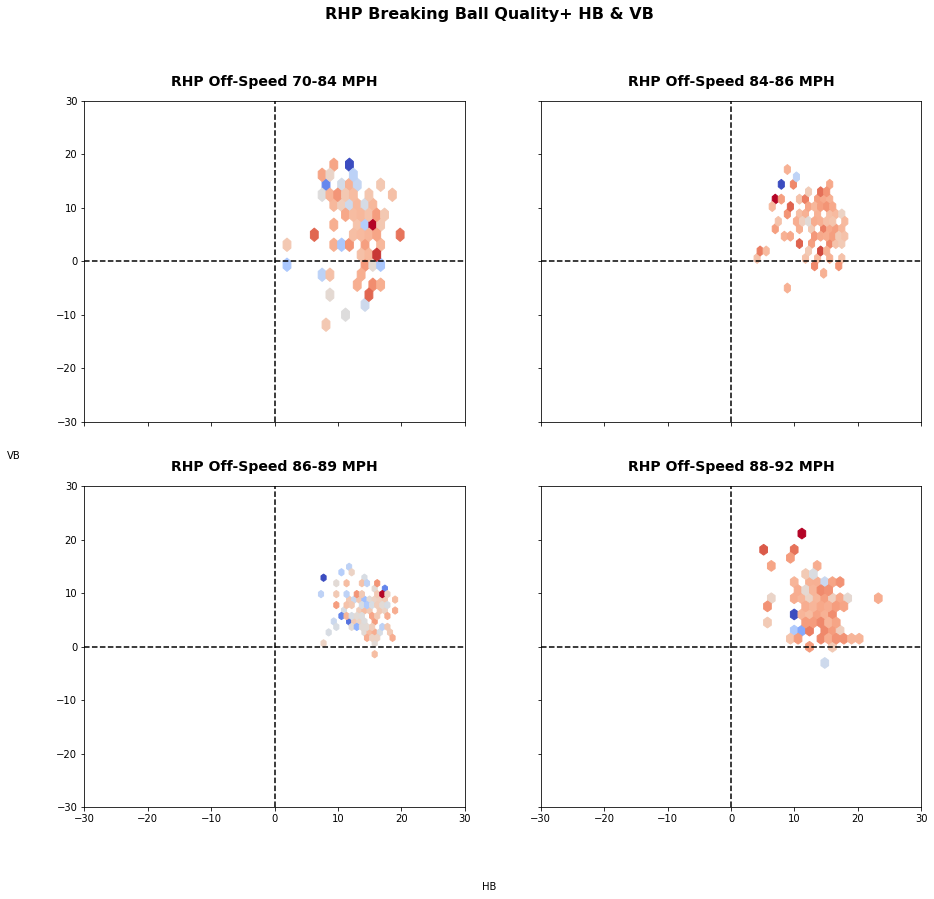

In [58]:
fig, axs = plt.subplots(2, 2, figsize = (15, 13), sharex = True, sharey = True)
fig.suptitle('RHP Breaking Ball Quality+ HB & VB', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -30, xmax = 30), plt.axis(ymin = -30, ymax = 30) 
fig.text(0.5, 0.04, 'HB', ha='center', va='center'), fig.text(0.06, 0.5, 'VB', ha='center', va='center')
axs[0][0].hexbin(bucket_1_r['pfx_x'], bucket_1_r['pfx_z'], C = bucket_1_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][0].axhline(0, color = 'black', ls = '--'),
axs[0][0].axvline(0, color = 'black', ls = '--')
#axs[0][0].fig.colorbar(shrink = .75)
#axs[0][0].ax.set_title('quality+')
axs[0][0].set_title('RHP Off-Speed 70-84 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[0][1].hexbin(bucket_2_r['pfx_x'], bucket_2_r['pfx_z'], C = bucket_2_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][1].axhline(0, color = 'black', ls = '--'),
axs[0][1].axvline(0, color = 'black', ls = '--')
axs[0][1].set_title('RHP Off-Speed 84-86 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][0].hexbin(bucket_3_r['pfx_x'], bucket_3_r['pfx_z'], C = bucket_3_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)

axs[1][0].axhline(0, color = 'black', ls = '--'),
axs[1][0].axvline(0, color = 'black', ls = '--')
axs[1][0].set_title('RHP Off-Speed 86-89 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][1].hexbin(bucket_4_r['pfx_x'], bucket_4_r['pfx_z'], C = bucket_4_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[1][1].axhline(0, color = 'black', ls = '--'),
axs[1][1].axvline(0, color = 'black', ls = '--')
axs[1][1].set_title('RHP Off-Speed 88-92 MPH', fontsize = 14, fontweight = 'bold', pad = 15);

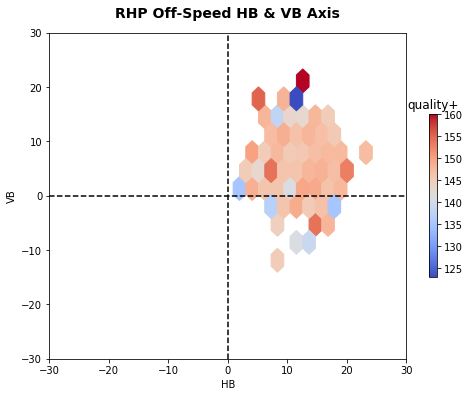

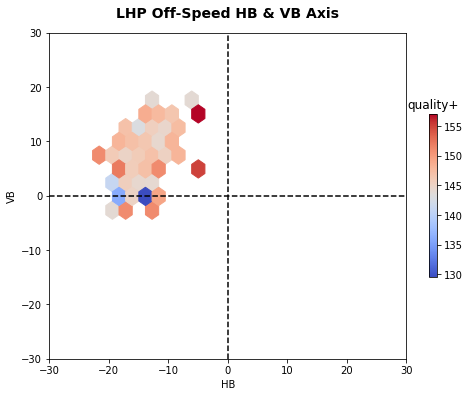

In [59]:
plt.figure(figsize = (8, 6))
plt.hexbin(os_r_lead['pfx_x'], os_r_lead['pfx_z'], C = os_r_lead['quality+'], cmap = 'coolwarm', gridsize = 10)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(os_l_lead['pfx_x'], os_l_lead['pfx_z'], C = os_l_lead['quality+'], cmap = 'coolwarm', gridsize = 8)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

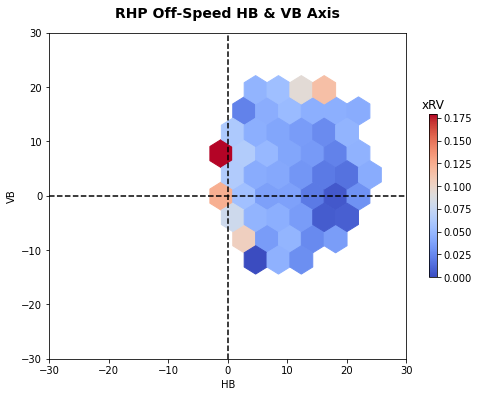

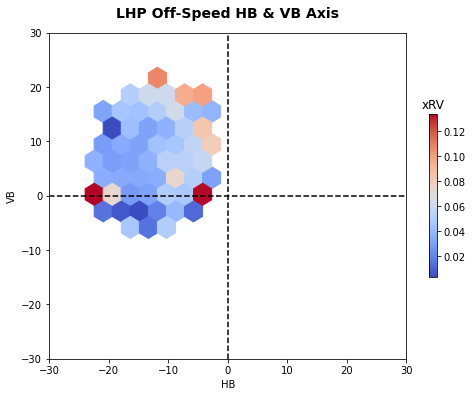

In [60]:
plt.figure(figsize = (8, 6))
plt.hexbin(os_r_stats['pfx_x'], os_r_stats['pfx_z'], C = os_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 10)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('xRV'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(os_l_stats['pfx_x'], os_l_stats['pfx_z'], C = os_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 10)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('xRV'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);